In [168]:
#-----------------------Laboratorio 09----------------------------
# Luiz Felipe Barros Alves

In [169]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

In [170]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
emeApi = lumapi.MODE(hide = False)

Exception ignored in: <function Lumerical.__del__ at 0x0000017C494782C0>
Traceback (most recent call last):
  File "C:\Program Files\Lumerical\v221\api\python\lumapi.py", line 1196, in __del__
    close(self.handle)
  File "C:\Program Files\Lumerical\v221\api\python\lumapi.py", line 245, in close
    iapi.appClose(handle)
ctypes.ArgumentError: argument 1: TypeError: expected Session instance instead of Session


## Especificação dos materiais e dimensões do guia

In [171]:
# units
um = 1e-6
nm = 1e-9

In [172]:
# Materiais 
sub_material = 'SiO2 (Glass) - Palik'
core_material = 'Si (Silicon) - Palik'

In [173]:
# MMI x parameters
L = 172.260 * um
W = 7.0 * um

# Taper parameters
W1 = 450 * nm
W2 = 1.5 * um
L1 = 15 * um

# Waveguide parameters
wvg_width = 450 * nm
wvg_height = 220 * nm

# Waveguide length
wvg_length = 4.0 * um

# Bandwidth operation
cband = True
filename = "S_MMI_EME_2x2_%d_um" % (L / um)

# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm


if cband:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
else:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um

nmbrFrqPnts = 20


## Criação da estrutura

In [174]:
# Definindo um grupo de estrutura
emeApi.addstructuregroup()
dev_layer = "GDS_LAYER 35:4"
emeApi.set("name", dev_layer)

In [175]:
emeApi.switchtolayout()
emeApi.deleteall()

# Adicionando um retângulo
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set("name", "box")
emeApi.set("x", 0)
emeApi.set("x span", L)
emeApi.set("y", 0)
emeApi.set("y span", W)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height)
emeApi.set("material", core_material)

# Configuração dos tapers
for i in range(4):
    emeApi.addobject("linear_taper")
    emeApi.set("name", f"taper port {str(i + 1)}")
    emeApi.set("thickness", wvg_height)
    emeApi.set("angle_side", 90)
    emeApi.set("width_r", W1)
    emeApi.set("width_l", W2)
    emeApi.set("len", L1)
    emeApi.set("material", core_material)
    emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x max") + L1/2)
    emeApi.set("y", 0)
    emeApi.set("z", wvg_height / 2)

# Ajustando as posições dos tapers
emeApi.select(f"{dev_layer}::taper port 1")
emeApi.set("width_r", W2)
emeApi.set("width_l", W1)
emeApi.set("x", -emeApi.getnamed(f"{dev_layer}::box", "x max") - L1/2)
emeApi.set("y", W/4)

emeApi.select(f"{dev_layer}::taper port 2")
emeApi.set("width_r", W2)
emeApi.set("width_l", W1)
emeApi.set("x", -emeApi.getnamed(f"{dev_layer}::box", "x max") - L1/2)
emeApi.set("y", -W/4)

emeApi.select(f"{dev_layer}::taper port 3")
emeApi.set("y", W/4)

emeApi.select(f"{dev_layer}::taper port 4")
emeApi.set("y", -W/4)

# Adicionando waveguides
for i in range(4):
    emeApi.addrect()
    emeApi.addtogroup(dev_layer)
    emeApi.set("name", f"wvguide {str(i+1)}")
    emeApi.set("x", 0)
    emeApi.set("x span", wvg_length)
    emeApi.set("y", 0)
    emeApi.set("y span", wvg_width)
    emeApi.set("z", wvg_height / 2)
    emeApi.set("z span", wvg_height)
    emeApi.set("material", core_material)

# Ajustando as posições dos wvg
emeApi.select(f"{dev_layer}::wvguide 1")
emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x min") - L1 - wvg_length/2)
emeApi.set("y", W/4)

emeApi.select(f"{dev_layer}::wvguide 2")
emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x min") - L1 - wvg_length/2)
emeApi.set("y", -W/4)

emeApi.select(f"{dev_layer}::wvguide 3")
emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x max") + L1 + wvg_length/2)
emeApi.set("y", W/4)

emeApi.select(f"{dev_layer}::wvguide 4")
emeApi.set("x", emeApi.getnamed(f"{dev_layer}::box", "x max") + L1 + wvg_length/2)
emeApi.set("y", -W/4)

## Adicionando solver

In [176]:
# Add solver

emeApi.switchtolayout()
emeApi.select('EME')
emeApi.delete()

bound_x_offset = 0.5 * um
bound_y_offset = 10 * um
bound_z_offset = 4 * um

emeApi.addeme()

## Dimensions
emeApi.set("x", 0)
emeApi.set("x min", emeApi.getnamed(f"{dev_layer}::wvguide 1", "x min"))

emeApi.set("y", 0)
emeApi.set("y span", W + bound_y_offset)

emeApi.set("z", wvg_height / 2)
emeApi.set("z span",  bound_z_offset)

## Background material
emeApi.set("background material", sub_material)


# Paramêtros importantes
cell_wgd = 1
cell_taper = 16
cell_box = 1

span_wgd = wvg_length 
span_taper = L1
span_box = L

method_wgd = 0  # 0 = none, 1 = CVCS
method_taper = 1
method_box = 0

modes_wgd = 4
modes_taper = 10
modes_box = 32

# Set cell properties
emeApi.set("number of cell groups", 5)
emeApi.set("group spans", np.block([[span_wgd], [span_taper], [span_box], [span_taper], [span_wgd]]))
emeApi.set("cells", np.block([[cell_wgd], [cell_taper], [cell_box], [cell_taper], [cell_wgd]]))
emeApi.set("subcell method", np.block([[method_wgd], [method_taper], [method_box], [method_taper], [method_wgd]]))
emeApi.set("allow custom eigensolver settings", True)
emeApi.set("modes", np.block([[modes_wgd], [modes_taper], [modes_box], [modes_taper], [modes_wgd]]))
emeApi.set("display cells", 1)

# Number of mesh cells without override regions
# emeApi.set("mesh cells x", 200)
emeApi.set("mesh cells y", 200)
emeApi.set("mesh cells z", 200)

# Boundary Conditions
emeApi.set("y min bc", "PML")
emeApi.set("y max bc", "PML")
emeApi.set("z min bc", "Symmetric")
emeApi.set("z max bc", "PML")


## Configura as portas
# port_y_span = 2 * um
# port_z_span = 2 * um

emeApi.select("EME::Ports::port_1")
emeApi.set("use full simulation span", 0)
emeApi.set("port location", "left")
emeApi.set("y", W/4)
emeApi.set("y span", wvg_width)
emeApi.set("z",wvg_height / 2)
emeApi.set("z span", wvg_height)
emeApi.set("mode selection","fundamental TE mode")

emeApi.select("EME::Ports::port_2")
emeApi.set("use full simulation span",0)
emeApi.set("port location", "left")
emeApi.set("y", -W/4)
emeApi.set("y span",  wvg_width)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height)
emeApi.set("mode selection","fundamental TE mode")

emeApi.addemeport()
emeApi.set("use full simulation span", 0)
emeApi.set("port location","right")
emeApi.set("y", W/4)
emeApi.set("y span", wvg_width)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height)
emeApi.set("mode selection","fundamental TE mode")

emeApi.addemeport()
emeApi.set("use full simulation span", 0)
emeApi.set("port location","right")
emeApi.set("y", -W/4)
emeApi.set("y span", wvg_width)
emeApi.set("z", wvg_height / 2)
emeApi.set("z span", wvg_height)
emeApi.set("mode selection","fundamental TE mode")

In [177]:
# add monitor

emeApi.switchtolayout()
emeApi.select('profile')
emeApi.delete()
emeApi.select('mesh')
emeApi.delete()

emeApi.addemeprofile()
emeApi.set("name", "profile")
emeApi.set("monitor type", 3) #2D Z normal
emeApi.set("x", 0)
emeApi.set("x span", emeApi.getnamed("EME", "x span"))
emeApi.set("y", 0)
emeApi.set("y span",  W + bound_y_offset)
emeApi.set("z", wvg_height / 2)

# emeApi.addmesh()
# emeApi.set("x", 0)
# emeApi.set("x span", emeApi.getnamed("EME", "x span") - 2*wvg_length)
# emeApi.set("y", 0)
# emeApi.set("y span",  W*2)
# emeApi.set("z", wvg_height / 2)
# emeApi.set("z span", wvg_height*5)

# emeApi.set("set mesh multiplier", True)
# emeApi.set("x mesh multiplier", 5)
# emeApi.set("y mesh multiplier", 5)
# emeApi.set("z mesh multiplier", 5)


## Simulação

In [178]:
emeApi.save(filename)
emeApi.run()

In [179]:
emeApi.emepropagate()

## Campo Elétrico

In [180]:
E = emeApi.getresult("profile", "field profile")

x = E['x']
x = x[:,0]/um
y = E['y']
y = y[:,0]/um
z = E['z']

E = E['E']

Ex = E[:, :, 0, :, 0]
Ey = E[:, :, 0, :, 1]
Ez = E[:, :, 0, :, 2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

Text(28, 3, 'Porta 2')

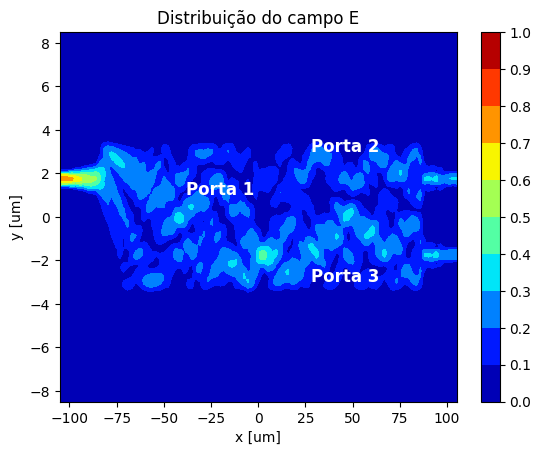

In [181]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 11, endpoint=True)
plt.contourf(x, y, np.transpose(Emag[:,:,0]), v, cmap=mycmap)
plt.colorbar(ticks=v)

plt.title('Distribuição do campo E', fontsize=12)
plt.ylabel('y [um]', fontsize=10)
plt.xlabel('x [um]', fontsize=10)

plt.text(-38, 1, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(28, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')
plt.text(28, 3, 'Porta 2', fontsize=12, fontweight='bold', color='w')


Text(28, 3, 'Porta 2')

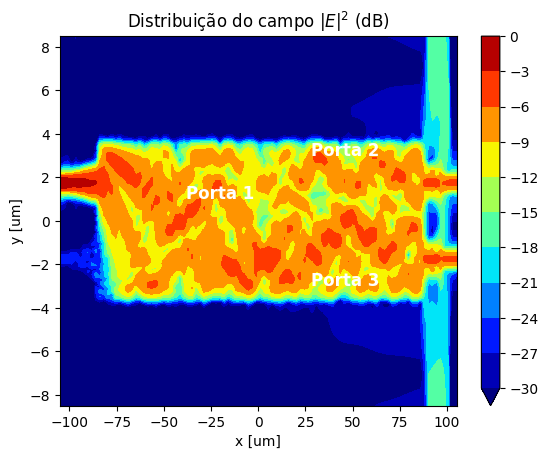

In [182]:
plt.figure()
v = np.linspace(-30, 0, 11, endpoint=True)

plt.title("Distribuição do campo $|E|^2$ (dB)", fontsize=12)
plt.ylabel("y [um]", fontsize=10)
plt.xlabel("x [um]", fontsize=10)

CS = plt.contourf(x, y, 10*np.log10(np.transpose(Emag[:,:,0])), v, cmap=mycmap, extend='min')
plt.colorbar(ticks=v)

plt.text(-38, 1, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(28, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')
plt.text(28, 3, 'Porta 2', fontsize=12, fontweight='bold', color='w')
